## Neural Style Transfer
Style transfer relies on separating the content and style of an image. Given one content image and one style image, we aim to create a new, target image which should contain our desired content and style components:

* objects and their arrangement are similar to that of the **content image**
* style, colors, and textures are similar to that of the **style image**


In [23]:
import torch
from torchvision import models
import torchvision.transforms as transforms
from torchvision.utils import save_image

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import requests
from io import BytesIO
%matplotlib inline

In [3]:
# Loading the model
model = models.vgg19(pretrained=True).features

In [4]:
# Freezing the layers
for param in model.parameters():
  param.requires_grad_(False)

In [5]:
# Select the device available
def get_device():
  if torch.cuda.is_available():
    return torch.device("cuda")
  else:
    return torch.device("cpu")
device = get_device()

In [6]:
device

device(type='cuda')

In [7]:
model.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [8]:
# loading content and style images
res = requests.get('https://raw.githubusercontent.com/soumyajit4419/Deep_Learning_Projects/master/Pytorch/Assets/person1.jpeg')
content = Image.open(BytesIO(res.content)).convert('RGB')

res = requests.get('https://raw.githubusercontent.com/soumyajit4419/Deep_Learning_Projects/master/Pytorch/Assets/paiting_night.jpeg')
style = Image.open(BytesIO(res.content)).convert('RGB')

In [9]:
# Applying transfroms to the images
height = 400
width = 500
transform = transforms.Compose([
                                transforms.Resize((height,width)),
                                transforms.ToTensor()
                              ])

content_image = transform(content)
style_image = transform(style)

torch.Size([3, 400, 500])
torch.Size([3, 400, 500])


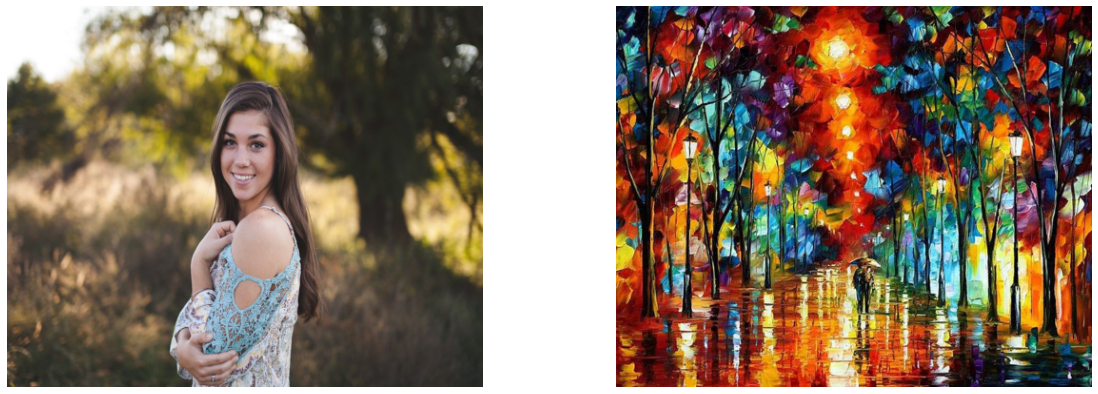

In [10]:
# Displaying the content and style images
print(content_image.shape)
print(style_image.shape)
fig , (ax1,ax2) = plt.subplots(figsize=(20,7),nrows=1,ncols=2)
ax1.imshow(content_image.permute(1,2,0))
ax1.axis("off")
ax2.imshow(style_image.permute(1,2,0))
ax2.axis("off")
plt.show()

In [11]:
#Adding a batch to image
content_image = content_image.unsqueeze(0)
style_image = style_image.unsqueeze(0)
# Moving the images to the device
content_image = content_image.to(device)
style_image = style_image.to(device)

In [12]:
def get_features(image, model, layers=None):
    """ Run an image forward through a model and get the features for 
        a set of layers. Default layers are for VGGNet matching Gatys et al (2016)
    """
    
    ## TODO: Complete mapping layer names of PyTorch's VGGNet to names from the paper
    ## Need the layers for the content and style representations of an image
    if layers is None:
        layers = {'0': 'conv1_1',
                  '5': 'conv2_1', 
                  '10': 'conv3_1', 
                  '19': 'conv4_1',
                  '21': 'conv4_2',  ## content representation
                  '28': 'conv5_1'}
        
    features = {}
    x = image
    # model._modules is a dictionary holding each module in the model
    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features[layers[name]] = x
            
    return features

In [13]:
def gram_matrix(tensor):
    """ Calculate the Gram Matrix of a given tensor 
        Gram Matrix: https://en.wikipedia.org/wiki/Gramian_matrix
    """
    # get the batch_size, depth, height, and width of the Tensor
    _, d, h, w = tensor.size()
    
    # reshape so we're multiplying the features for each channel
    tensor = tensor.view(d, h * w)
    
    # calculate the gram matrix
    gram = torch.mm(tensor, tensor.t())
    
    return gram

In [14]:
content_features = get_features(content_image, model)
style_features = get_features(style_image, model)

style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}

In [15]:
target = content_image.clone().requires_grad_(True).to(device)

In [16]:
# weights for each style layer 
# weighting earlier layers more will result in *larger* style artifacts
# notice we are excluding `conv4_2` our content representation
style_weights = {'conv1_1': 1.,
                 'conv2_1': 0.75,
                 'conv3_1': 0.2,
                 'conv4_1': 0.2,
                 'conv5_1': 0.2}

content_weight = 1  # alpha
style_weight = 1e6  # beta

In [17]:
def im_convert(target):
  image = target.to("cpu").clone().detach()
  image = image.squeeze()
  return image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Total loss:  124278.2578125


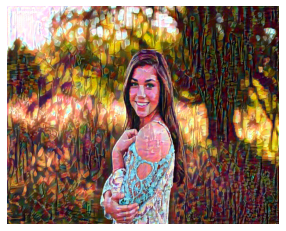

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Total loss:  54565.98046875


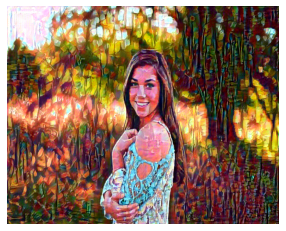

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Total loss:  31518.34375


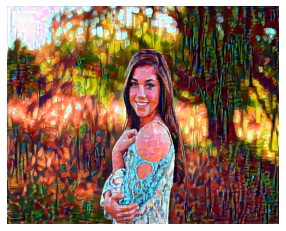

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Total loss:  20656.669921875


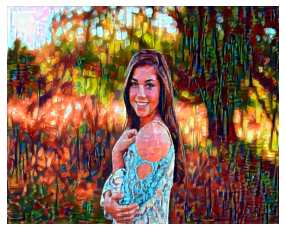

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Total loss:  15277.9619140625


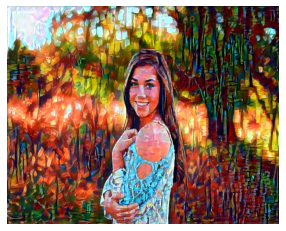

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Total loss:  12092.9091796875


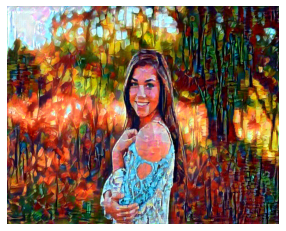

In [18]:
# for displaying the target image, intermittently
show_every = 500

# iteration hyperparameters
optimizer = torch.optim.Adam([target], lr=0.003)
steps = 3000  # decide how many iterations to update your image (5000)

for ii in range(1, steps+1):
    
    # get the features from your target image
    target_features = get_features(target, model)
    
    # the content loss
    content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2'])**2)
    
    # the style loss
    # initialize the style loss to 0
    style_loss = 0
    # then add to it for each layer's gram matrix loss
    for layer in style_weights:
        # get the "target" style representation for the layer
        target_feature = target_features[layer]
        target_gram = gram_matrix(target_feature)
        _, d, h, w = target_feature.shape
        # get the "style" style representation
        style_gram = style_grams[layer]
        # the style loss for one layer, weighted appropriately
        layer_style_loss = style_weights[layer] * torch.mean((target_gram - style_gram)**2)
        # add to the style loss
        style_loss += layer_style_loss / (d * h * w)
        
    # calculate the *total* loss
    total_loss = content_weight * content_loss + style_weight * style_loss
    
    # update your target image
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    
    # display intermediate images and print the loss
    if  ii % show_every == 0:
        print('Total loss: ', total_loss.item())
        tag_img = im_convert(target)
        plt.imshow(tag_img.permute(1,2,0))
        plt.axis("off")
        plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


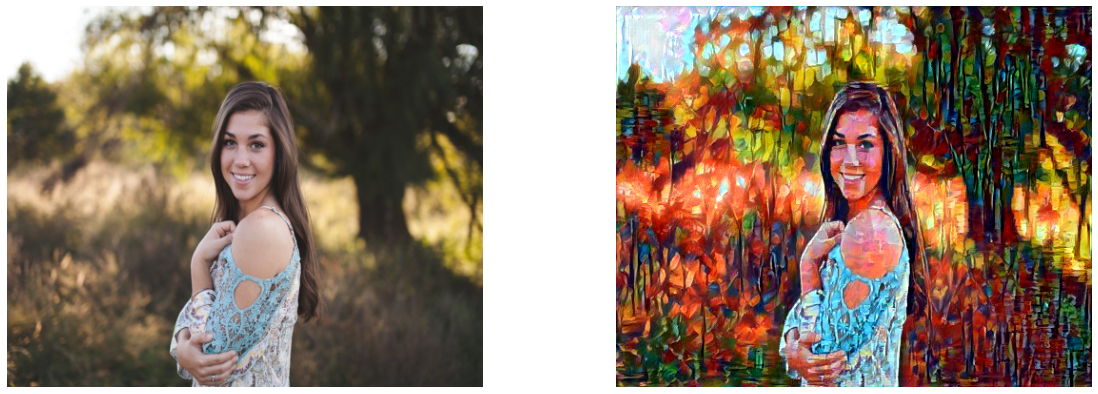

In [24]:
ci = im_convert(content_image)
ti = im_convert(target)
fig , (ax1,ax2) = plt.subplots(figsize=(20,7),nrows=1,ncols=2)
ax1.imshow(ci.permute(1,2,0))
ax1.axis("off")
ax2.imshow(ti.permute(1,2,0))
ax2.axis("off")
plt.show()

In [26]:
save_image(ti, 'girl_paiting.png')